In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.utils as vutils
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Subset
import numpy as np
import torch.nn.functional as F

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(
                features_g * 2, channels_img, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)


In [5]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid()
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [8]:
import torch

# Load saved weights
G = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
D = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
G.load_state_dict(torch.load("/kaggle/input/dcgan/generator.pth"))
D.load_state_dict(torch.load("/kaggle/input/dcgan/discriminator.pth"))

# Freeze G and D (no gradients)
for param in G.parameters():
    param.requires_grad = False
for param in D.parameters():
    param.requires_grad = False

G.eval()
D.eval()

/tmp/ipykernel_31/3232844429.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load("/kaggle/input/dcgan/generator.pth"))
/tmp/ipykernel_31/3232844

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [23]:
import torch
import torch.nn as nn

class TrajectoryNet(nn.Module):
    def __init__(self, latent_dim=100, steps=10):
        super().__init__()
        self.steps = steps
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, steps * latent_dim)
        )

    def forward(self, z0):
        traj = self.fc(z0)  # (1, steps * latent_dim)
        traj = traj.view(self.steps, -1)  # (steps, latent_dim)
        return traj

In [24]:
def smoothness_loss(traj):
    diffs = traj[1:] - traj[:-1]
    return torch.mean(diffs ** 2)

In [29]:
def realism_loss(discriminator, generator, traj):
    traj = traj.unsqueeze(-1).unsqueeze(-1)  # Fix shape
    fake_images = generator(traj)
    preds = discriminator(fake_images)
    return -torch.mean(preds)  # maximize D(fake) == real

In [32]:
discriminator = D  
generator = G

In [33]:
# Setup
latent_dim = 100
trajectory_net = TrajectoryNet(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(trajectory_net.parameters(), lr=1e-3)

# Training
for epoch in range(500):
    z0 = torch.randn(1, latent_dim).to(device)  # sample latent
    traj = trajectory_net(z0)

    # Get losses
    loss_real = realism_loss(discriminator, generator, traj)
    loss_smooth = smoothness_loss(traj)

    total_loss = loss_real + 0.1 * loss_smooth  # weight smoothness

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss.item():.4f}")

Epoch 0: Loss = -0.1155
Epoch 50: Loss = -0.6395
Epoch 100: Loss = -0.6250
Epoch 150: Loss = -0.8366
Epoch 200: Loss = -0.8755
Epoch 250: Loss = -0.6205
Epoch 300: Loss = -0.7543
Epoch 350: Loss = -0.8574
Epoch 400: Loss = -0.8591
Epoch 450: Loss = -0.9002


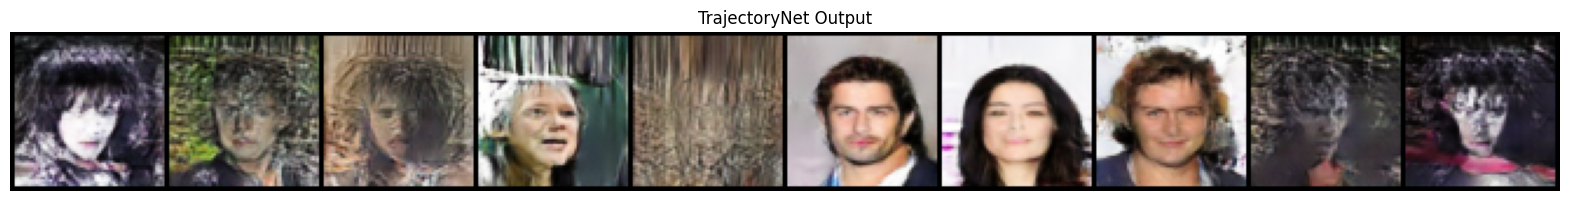

In [36]:
with torch.no_grad():
    z0 = torch.randn(1, latent_dim).to(device)
    traj = trajectory_net(z0)  # (steps, latent_dim)
    steps = traj.shape[0]  # infer number of steps
    traj = traj.view(steps, latent_dim, 1, 1)  # reshape for generator
    fake_imgs = generator(traj).cpu()

import matplotlib.pyplot as plt
import torchvision.utils as vutils
import numpy as np

grid = vutils.make_grid(fake_imgs, nrow=steps, normalize=True, padding=2)
plt.figure(figsize=(20, 5))
plt.axis("off")
plt.title("TrajectoryNet Output")
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

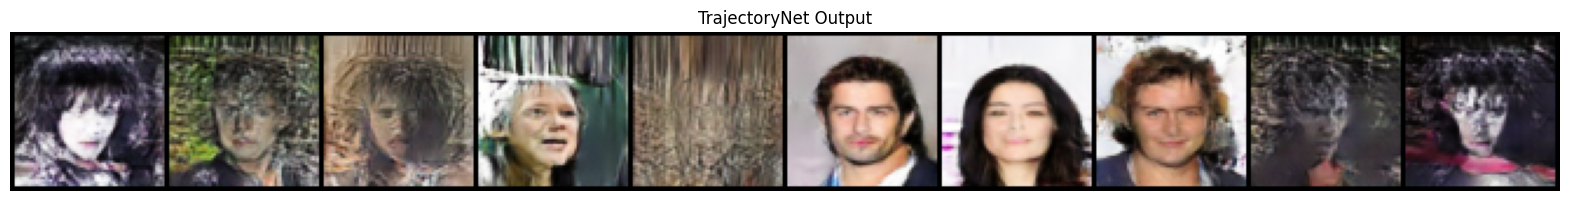

In [39]:
grid = vutils.make_grid(fake_imgs, nrow=steps, normalize=True, padding=2)
plt.figure(figsize=(20, 5))
plt.axis("off")
plt.title("TrajectoryNet Output")
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

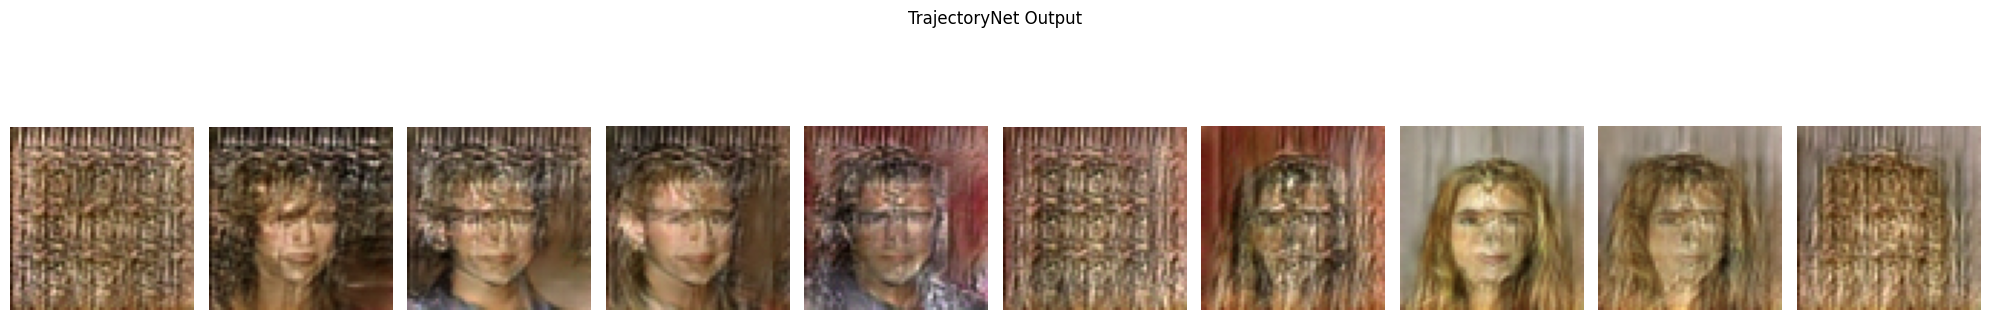

In [41]:
steps = 10
expected_latent_dim = trajectory_net.fc[0].in_features
z0 = torch.randn(1, expected_latent_dim).to(device)

traj = trajectory_net(z0)  # shape: (steps, latent_dim)
traj = traj.view(steps, -1, 1, 1)

# Optional: Smooth latent trajectory
traj = F.avg_pool1d(traj.view(1, -1, steps), kernel_size=3, stride=1, padding=1).squeeze(0).permute(1, 0).unsqueeze(2).unsqueeze(3)
with torch.no_grad():
    fake_imgs = generator(traj).cpu()

# Plot
fig, axs = plt.subplots(1, steps, figsize=(20, 4))
for i in range(steps):
    img = fake_imgs[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())
    axs[i].imshow(img)
    axs[i].axis('off')
plt.suptitle('TrajectoryNet Output')
plt.tight_layout()
plt.show()

In [44]:
def realism_loss(discriminator, generator, traj):
    fake_images = generator(traj)  # traj already has shape [steps, latent_dim, 1, 1]
    preds = discriminator(fake_images)
    return -torch.mean(preds)  # maximize D(fake) == real

In [45]:
# Setup
latent_dim = 100
steps = 20
trajectory_net = TrajectoryNet(latent_dim=latent_dim, steps=steps).to(device)
optimizer = torch.optim.Adam(trajectory_net.parameters(), lr=1e-3)

# Training
for epoch in range(500):
    z0 = torch.randn(1, latent_dim).to(device)
    traj = trajectory_net(z0)  # (steps, latent_dim)

    traj = traj.view(steps, latent_dim, 1, 1)  # this is enough
    fake_imgs = generator(traj)  # (steps, C, H, W)

    # Loss 1: Adversarial realism
    loss_real = realism_loss(discriminator, generator, traj)

    # Loss 2: Smoothness in latent space (already defined)
    loss_smooth = smoothness_loss(traj)

    # Loss 3: Diversity in image space — prevent mode collapse
    diversity_loss = 0
    for i in range(steps):
        for j in range(i + 1, steps):
            diversity_loss += (fake_imgs[i] - fake_imgs[j]).pow(2).mean()
    diversity_loss /= (steps * (steps - 1) / 2)

    # Total loss
    total_loss = loss_real + 0.1 * loss_smooth - 0.05 * diversity_loss  # tune weights as needed

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {total_loss.item():.4f}")

Epoch 0: Loss = -0.1484
Epoch 50: Loss = -0.5616
Epoch 100: Loss = -0.7947
Epoch 150: Loss = -0.7090
Epoch 200: Loss = -0.8364
Epoch 250: Loss = -0.7974
Epoch 300: Loss = -0.9450
Epoch 350: Loss = -0.9028
Epoch 400: Loss = -0.9535
Epoch 450: Loss = -0.9026


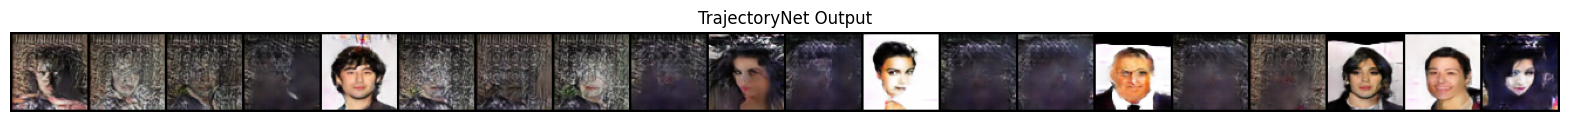

In [48]:
grid = vutils.make_grid(fake_imgs, nrow=steps, normalize=True, padding=2)
plt.figure(figsize=(20, 5))
plt.axis("off")
plt.title("TrajectoryNet Output")
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0))); plt.show()

In [ ]:
pip install pytorch-fid

In [56]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split
import os
from tqdm import tqdm
from pytorch_fid import fid_score
from torch.nn import functional as F
from scipy.stats import entropy
import numpy as np
from torchvision.models.inception import inception_v3
from PIL import Image

# --- CONFIG ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
NUM_GEN_IMAGES = 5000  # for FID/IS
IMG_SIZE = 64
DATASET_PATH = "/kaggle/input/celeba-dataset/img_align_celeba"

# --- TRANSFORMS ---
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# --- LOAD DATASET ---
dataset = torchvision.datasets.ImageFolder(
    root=os.path.join(DATASET_PATH, ".."),  # parent folder containing img_align_celeba
    transform=transform
)

# --- MANUAL SPLIT: TRAIN + TEST ---
test_size = 5000
train_size = len(dataset) - test_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- LOAD MODELS ---
# Replace these with your actual generator and discriminator
G = generator
D = discriminator
G.eval()
D.eval()

# --- GENERATE FAKE IMAGES ---
os.makedirs("generated", exist_ok=True)

with torch.no_grad():
    for i in tqdm(range(0, NUM_GEN_IMAGES, BATCH_SIZE)):
        noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=device)
        fake_images = G(noise)
        fake_images = (fake_images + 1) / 2  # Rescale to [0,1]

        for j in range(fake_images.size(0)):
            idx = i + j
            if idx >= NUM_GEN_IMAGES:
                break
            save_image(fake_images[j], f"generated/gen_{idx}.png")

# --- SAVE REAL IMAGES ---
os.makedirs("real", exist_ok=True)
count = 0

with torch.no_grad():
    for imgs, _ in test_loader:
        if count >= NUM_GEN_IMAGES:
            break
        for img in imgs:
            if count >= NUM_GEN_IMAGES:
                break
            save_image((img + 1) / 2, f"real/real_{count}.png")
            count += 1

# --- CALCULATE FID ---
fid = fid_score.calculate_fid_given_paths(['real', 'generated'], batch_size=50, device=device, dims=2048)
print(f"FID: {fid:.2f}")

# --- CALCULATE INCEPTION SCORE ---
def inception_score(imgs, splits=10):
    N = len(imgs)
    assert N > 0
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_pred(x):
        x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
        return inception_model(x)

    preds = []
    with torch.no_grad():
        for i in range(0, N, BATCH_SIZE):
            batch = torch.stack(imgs[i:i+BATCH_SIZE]).to(device)
            pred = get_pred(batch)
            preds.append(F.softmax(pred, dim=1).cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    scores = []

    for i in range(splits):
        part = preds[i * (N // splits): (i + 1) * (N // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        scores.append(np.exp(np.mean(np.sum(kl, axis=1))))
    return np.mean(scores), np.std(scores)

# --- LOAD GENERATED IMAGES FOR IS ---
gen_imgs = []
for filename in sorted(os.listdir("generated"))[:NUM_GEN_IMAGES]:
    img = Image.open(os.path.join("generated", filename)).convert("RGB")
    img = transform(img)
    gen_imgs.append(img)

is_mean, is_std = inception_score(gen_imgs)
print(f"Inception Score: {is_mean:.2f} ± {is_std:.2f}")

100%|██████████| 102/102 [00:10<00:00,  9.30it/s]


FID: 32.18
Inception Score: 2.90 ± 0.08
